In [442]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, recall_score, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
import xgboost as xg
from xgboost.sklearn import XGBClassifier
from sklearn.learning_curve import validation_curve

from scipy.stats import randint, uniform

seed = 26

# Read Data

In [334]:
demand_data = pd.read_csv("data/ZonalDemands_2003-2017.csv")
weather_data = pd.read_csv("data/weather_data_2002_2018.csv",index_col=0)

C:\Users\trevo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\trevo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [335]:
demand_data['Date'] = pd.to_datetime(demand_data['Date']) + pd.to_timedelta(demand_data['Hour'], unit='h')

In [336]:
#remove zones
demand_data.drop(demand_data.columns[3:],axis = 1, inplace=True)
demand_data.head()

,Date,Hour,Total Ontario
0,2003-05-01 01:00:00,1,13702
1,2003-05-01 02:00:00,2,13578
2,2003-05-01 03:00:00,3,13411
3,2003-05-01 04:00:00,4,13501
4,2003-05-01 05:00:00,5,14010


In [337]:
weather_data['Date/Time'] = pd.to_datetime(weather_data['Date/Time'])
weather_data.head()

,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,2001-01-01 00:00:00,2001,1,1,00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001-01-01 01:00:00,2001,1,1,01:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001-01-01 02:00:00,2001,1,1,02:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-01-01 03:00:00,2001,1,1,03:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001-01-01 04:00:00,2001,1,1,04:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Merge Datasets

In [338]:
weather_data = weather_data.rename(index=str, columns = {"Date/Time":"Date"})

In [339]:
data = demand_data.merge(right=weather_data, how='left', on='Date')

In [340]:
data.head(2)

,Date,Hour,Total Ontario,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,2003-05-01 01:00:00,1,13702,2003,5,1,01:00,9.2,NaN,3.0,...,M,NaN,M,99.84,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-05-01 02:00:00,2,13578,2003,5,1,02:00,8.1,NaN,5.1,...,M,NaN,M,99.72,NaN,NaN,NaN,NaN,NaN,NaN


In [341]:
data.drop('Time', axis = 1, inplace = True)

In [342]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128616 entries, 0 to 128615
Data columns (total 25 columns):
Date                   128616 non-null datetime64[ns]
Hour                   128616 non-null int64
Total Ontario          128616 non-null int64
Year                   128616 non-null int64
Month                  128616 non-null int64
Day                    128616 non-null int64
Temp (°C)              126884 non-null float64
Temp Flag              6 non-null object
Dew Point Temp (°C)    126885 non-null float64
Dew Point Temp Flag    5 non-null object
Rel Hum (%)            126885 non-null float64
Rel Hum Flag           5 non-null object
Wind Dir (10s deg)     0 non-null float64
Wind Dir Flag          126883 non-null object
Wind Spd (km/h)        283 non-null float64
Wind Spd Flag          126883 non-null object
Visibility (km)        0 non-null float64
Visibility Flag        13295 non-null object
Stn Press (kPa)        123095 non-null float64
Stn Press Flag         3795 non-nu

# Create Dummies for Categorical Features

In [343]:
data_cat_features = [pcol for pcol in data.columns if data[pcol].dtype == 'object']
data_cat_features

['Temp Flag',
 'Dew Point Temp Flag',
 'Rel Hum Flag',
 'Wind Dir Flag',
 'Wind Spd Flag',
 'Visibility Flag',
 'Stn Press Flag']

In [344]:
data = pd.get_dummies(data, columns=data_cat_features)

In [345]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128616 entries, 0 to 128615
Data columns (total 25 columns):
Date                     128616 non-null datetime64[ns]
Hour                     128616 non-null int64
Total Ontario            128616 non-null int64
Year                     128616 non-null int64
Month                    128616 non-null int64
Day                      128616 non-null int64
Temp (°C)                126884 non-null float64
Dew Point Temp (°C)      126885 non-null float64
Rel Hum (%)              126885 non-null float64
Wind Dir (10s deg)       0 non-null float64
Wind Spd (km/h)          283 non-null float64
Visibility (km)          0 non-null float64
Stn Press (kPa)          123095 non-null float64
Hmdx                     21457 non-null float64
Hmdx Flag                0 non-null float64
Wind Chill               0 non-null float64
Wind Chill Flag          0 non-null float64
Weather                  0 non-null float64
Temp Flag_M              128616 non-null uin

# Feature Creation/Engineering

In [346]:
#add day of week (Sun-Sat)
data['Day of Week'] = data['Date'].apply(lambda x: x.dayofweek)

In [347]:
#add Heating/Cooling Degree Days

talpha = 14.5
tbeta = 14.5

data['CDD'] = (data['Temp (°C)']-talpha)
data['HDD'] = (tbeta-data['Temp (°C)'])

data['CDD'][data['CDD'] < 0] = 0
data['HDD'][data['HDD'] < 0] = 0

C:\Users\trevo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\trevo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [348]:
data.set_index('Date',drop=True, inplace = True)
data.head(1)

,Hour,Total Ontario,Year,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),...,Temp Flag_M,Dew Point Temp Flag_M,Rel Hum Flag_M,Wind Dir Flag_M,Wind Spd Flag_M,Visibility Flag_M,Stn Press Flag_M,Day of Week,CDD,HDD
Date,,,,,,,,,,,,,,,,,,,,,
2003-05-01 01:00:00,1,13702,2003,5,1,9.2,3.0,65.0,NaN,NaN,...,0,0,0,1,1,1,0,3,0.0,5.3


In [349]:
#add top five days (add 1 for whole day i.e 24 1's per day or 24*5 1's per year)
top_days = 5

data['topdays'] = 0

for year in range(data['Year'].min(),data['Year'].max()+1):

    indices = data[data['Year'] == year].resample('D').max().nlargest(top_days,'Total Ontario').index

    for i in range(len(indices)):
        
        y = data[data.index == indices[i]]['Year'].as_matrix()[0]
        m = data[data.index == indices[i]]['Month'].as_matrix()[0]
        d = data[data.index == indices[i]]['Day'].as_matrix()[0]
        
        data.loc[data[(data['Year'] == y) & (data['Month'] == m) & (data['Day'] == d)].index, 'topdays'] = 1

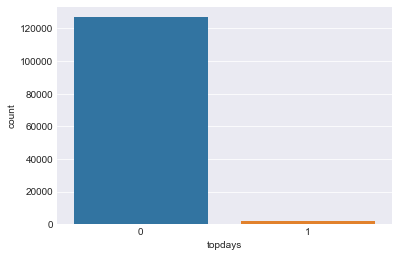

In [350]:
#data[(data['topdays']==1) & (data['Year'] == 2017)]

sns.countplot(x='topdays',data=data)

severely imbalanced, will need to weight topdays more heavily

In [351]:
data.head(1)

,Hour,Total Ontario,Year,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),...,Dew Point Temp Flag_M,Rel Hum Flag_M,Wind Dir Flag_M,Wind Spd Flag_M,Visibility Flag_M,Stn Press Flag_M,Day of Week,CDD,HDD,topdays
Date,,,,,,,,,,,,,,,,,,,,,
2003-05-01 01:00:00,1,13702,2003,5,1,9.2,3.0,65.0,NaN,NaN,...,0,0,1,1,1,0,3,0.0,5.3,0


# Clean Data

In [352]:
#Remove Features witrh 80% Missing
data = data[data.columns[data.isnull().mean() < 0.80]]

In [353]:
#get target variable
y = data['topdays']
del data['topdays']

In [354]:
del data['Year']

In [355]:
data.head(1)

,Hour,Total Ontario,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Stn Press (kPa),Temp Flag_M,Dew Point Temp Flag_M,Rel Hum Flag_M,Wind Dir Flag_M,Wind Spd Flag_M,Visibility Flag_M,Stn Press Flag_M,Day of Week,CDD,HDD
Date,,,,,,,,,,,,,,,,,,
2003-05-01 01:00:00,1,13702,5,1,9.2,3.0,65.0,99.84,0,0,0,1,1,1,0,3,0.0,5.3


In [290]:
y[0:5]

Date
2003-05-01 01:00:00    0
2003-05-01 02:00:00    0
2003-05-01 03:00:00    0
2003-05-01 04:00:00    0
2003-05-01 05:00:00    0
Name: topdays, dtype: int64

# XG Boost

In [357]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128616 entries, 2003-05-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 18 columns):
Hour                     128616 non-null int64
Total Ontario            128616 non-null int64
Month                    128616 non-null int64
Day                      128616 non-null int64
Temp (°C)                126884 non-null float64
Dew Point Temp (°C)      126885 non-null float64
Rel Hum (%)              126885 non-null float64
Stn Press (kPa)          123095 non-null float64
Temp Flag_M              128616 non-null uint8
Dew Point Temp Flag_M    128616 non-null uint8
Rel Hum Flag_M           128616 non-null uint8
Wind Dir Flag_M          128616 non-null uint8
Wind Spd Flag_M          128616 non-null uint8
Visibility Flag_M        128616 non-null uint8
Stn Press Flag_M         128616 non-null uint8
Day of Week              128616 non-null int64
CDD                      126884 non-null float64
HDD                      126884 non-null float

# GridSearch

In [422]:
cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=seed)

In [423]:
params_grid = {
    'max_depth': [2,3,4,5],
    'n_estimators': [25,50,100],
    'learning_rate': np.linspace(0.01, 2, 5),
    'colsample_bytree': np.linspace(0.05, 1, 5), 
}

In [424]:
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1,
    'scale_pos_weight': float(np.sum(y == 0)) / np.sum(y == 1), #imbalanced set, this weights topdays more heavily
}

In [425]:
#score based on recall (imbalanced set)
scoring = {'AUC': make_scorer(roc_auc_score), 'Recall': make_scorer(recall_score)}

In [426]:
bst_grid = GridSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=seed),
    param_grid=params_grid,
    cv=cv,
    scoring=scoring,
    refit='AUC',
    verbose = 10,
)

In [428]:
bst_grid.fit(data,y) #started 4:29

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.8973454785614274, Recall=0.9392265193370166, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.8943414988873118, Recall=0.9277777777777778, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.8743845169882073, Recall=0.8888888888888888, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.901255497730817, Recall=0.9444444444444444, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s


[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.9037178678441886, Recall=0.95, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s


[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.8905725100544121, Recall=0.9222222222222223, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.5s remaining:    0.0s


[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.8973681097705228, Recall=0.9388888888888889, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.1s remaining:    0.0s


[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.9024899455878874, Recall=0.95, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.7s remaining:    0.0s


[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.900719580474726, Recall=0.9388888888888889, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.3s remaining:    0.0s


[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.8922462739531583, Recall=0.9277777777777778, total=   0.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.8996426396310602, Recall=0.9613259668508287, total=   0.7s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.895044157073017, Recall=0.95, total=   0.8s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.8990047135923181, Recall=0.9555555555555556, total=   1.0s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.9050513413587062, Recall=0.972222222222222

[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=3, n_estimators=50, AUC=0.9075861525116315, Recall=0.9777777777777777, total=   0.7s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=3, n_estimators=50, AUC=0.9099518965381279, Recall=0.9777777777777777, total=   0.8s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=3, n_estimators=50, AUC=0.8971453355413611, Recall=0.9555555555555556, total=   1.5s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.8972744682723415, Recall=0.9558011049723757, total=   3.0s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.898847009760115, Recall

[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=4, n_estimators=100, AUC=0.9051122325605846, Recall=0.9666666666666667, total=   3.4s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=4, n_estimators=100, AUC=0.9131633940540967, Recall=0.9833333333333333, total=   2.2s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=4, n_estimators=100, AUC=0.9076078384985413, Recall=0.9722222222222222, total=   1.8s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=4, n_estimators=100, AUC=0.9028980364324581, Recall=0.9666666666666667, total=   2.3s
[CV] colsample_bytree=0.05, learning_rate=0.01, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.01, max_depth=4, n_estimators=100, AUC=0.9112136266855928, 

[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=2, n_estimators=25, AUC=0.9141477860134223, Recall=0.9444444444444444, total=   0.4s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=2, n_estimators=25, AUC=0.9209255462685522, Recall=0.9555555555555556, total=   0.5s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=2, n_estimators=25, AUC=0.9188933571641348, Recall=0.9611111111111111, total=   0.4s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=2, n_estimators=25, AUC=0.9156639331335751, Recall=0.95, total=   0.4s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=2, n_estimators=25, AUC=0.9111288541913098, Recal

[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=3, n_estimators=25, AUC=0.9275372604684173, Recall=0.9777777777777777, total=   0.5s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=3, n_estimators=25, AUC=0.9217234445233026, Recall=0.9722222222222222, total=   0.4s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.9372892018182118, Recall=0.9502762430939227, total=   0.8s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.935810597697524, Recall=0.95, total=   1.0s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.9532263575671556, Recall

[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=4, n_estimators=50, AUC=0.9488112136266856, Recall=0.9722222222222222, total=   0.9s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=4, n_estimators=50, AUC=0.9524741739610442, Recall=0.9833333333333333, total=   1.7s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=4, n_estimators=50, AUC=0.9446534185001183, Recall=0.9666666666666667, total=   1.8s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=4, n_estimators=50, AUC=0.9460334358489079, Recall=0.9666666666666667, total=   1.1s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=4, n_estimators=50, AUC=0.946839760

[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=5, n_estimators=100, AUC=0.9512835339676532, Recall=0.9555555555555556, total=   1.7s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=5, n_estimators=100, AUC=0.957014754069635, Recall=0.9722222222222222, total=   3.5s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=5, n_estimators=100, AUC=0.9483480523576724, Recall=0.95, total=   4.3s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=5, n_estimators=100, AUC=0.9506505796072865, Recall=0.9555555555555556, total=   3.8s
[CV] colsample_bytree=0.05, learning_rate=0.5075, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=0.5075, max_depth=5, n_estimators=100, AUC=0.960578818705149

[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=2, n_estimators=100, AUC=0.9634748836842519, Recall=0.9833333333333333, total=   1.4s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9270410666006809, Recall=0.9558011049723757, total=   0.5s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9225240498344109, Recall=0.95, total=   0.5s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9203591266712225, Recall=0.9388888888888889, total=   0.5s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9291046802992868, Recall=0.9611

[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=4, n_estimators=25, AUC=0.9207672896459269, Recall=0.9444444444444444, total=   0.5s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=4, n_estimators=25, AUC=0.9288640485766108, Recall=0.9611111111111111, total=   0.6s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=4, n_estimators=25, AUC=0.9234484662092894, Recall=0.9444444444444444, total=   1.1s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=4, n_estimators=25, AUC=0.9330395867833767, Recall=0.9722222222222222, total=   1.1s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.9460417645054853, 

[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=5, n_estimators=50, AUC=0.9409000508156793, Recall=0.9388888888888889, total=   1.1s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=5, n_estimators=50, AUC=0.9477172370288598, Recall=0.95, total=   1.0s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=5, n_estimators=50, AUC=0.9452921693872722, Recall=0.9444444444444444, total=   1.4s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=5, n_estimators=50, AUC=0.9542346818074284, Recall=0.9666666666666667, total=   2.1s
[CV] colsample_bytree=0.05, learning_rate=1.005, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=1.005, max_depth=5, n_estimators=50, AUC=0.9503351470704203, Recall=0.95555

[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.9345189292519697, Recall=0.9281767955801105, total=   3.1s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.9209395643869701, Recall=0.9111111111111111, total=   2.7s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.9404269393190698, Recall=0.9388888888888889, total=   2.5s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.8882909285251188, Recall=0.8611111111111112, total=   1.9s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.

[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=3, n_estimators=100, AUC=0.9649160160870593, Recall=0.9777777777777777, total=   1.5s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=3, n_estimators=100, AUC=0.9003450043371974, Recall=0.8833333333333333, total=   2.6s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=3, n_estimators=100, AUC=0.940367478905449, Recall=0.9333333333333333, total=   3.5s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.8879307340372791, Recall=0.8729281767955801, total=   1.0s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.90168

[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=5, n_estimators=25, AUC=0.9043627012914192, Recall=0.9055555555555556, total=   0.8s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=5, n_estimators=25, AUC=0.9006564939673527, Recall=0.8944444444444445, total=   0.7s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=5, n_estimators=25, AUC=0.9080041006229792, Recall=0.9111111111111111, total=   0.6s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=5, n_estimators=25, AUC=0.9036491601608706, Recall=0.9055555555555556, total=   0.7s
[CV] colsample_bytree=0.05, learning_rate=1.5025, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=1.5025, max_depth=5, n_estimators=25, AUC=0.907749783

[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.5, Recall=1.0, total=   0.6s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.5, Recall=1.0, total=   0.6s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.5, Recall=1.0, total=   0.6s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.5, Recall=1.0, total=   0.7s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.5, Recall=1.0, total=   0.5s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, ma

[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.5, Recall=0.0, total=   1.0s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.5, Recall=1.0, total=   1.0s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.5, Recall=0.0, total=   1.0s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.5, Recall=0.0, total=   1.0s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=4, n_estimators=25, AUC=0.5, Recall=0.0, total=   0.5s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.05, learning_rate=

[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=25, AUC=0.5, Recall=0.0, total=   0.4s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=50, AUC=0.5, Recall=1.0, total=   0.7s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=50, AUC=0.5, Recall=0.0, total=   0.7s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=50, AUC=0.5, Recall=0.0, total=   0.6s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=50, AUC=0.5, Recall=0.0, total=   0.6s
[CV] colsample_bytree=0.05, learning_rate=2.0, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.05, learning_rate=2.0, ma

[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.9077773834871067, Recall=0.9388888888888889, total=   1.1s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=2, n_estimators=100, AUC=0.9107555320500366, Recall=0.9502762430939227, total=   2.5s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=2, n_estimators=100, AUC=0.9053593018977028, Recall=0.9333333333333333, total=   2.6s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=2, n_estimators=100, AUC=0.8851872294941211, Recall=0.8888888888888888, total=   2.0s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=2, n_estimators=100, AUC=0.9

[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.926792051100071, Recall=0.9666666666666667, total=   4.7s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.927282942985569, Recall=0.9722222222222222, total=   3.2s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.9269497673685041, Recall=0.9666666666666667, total=   2.6s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.9255697500197146, Recall=0.9666666666666667, total=   3.4s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=4, n_estimators=25, AUC=0.9188

[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.9377319560531989, Recall=0.9833333333333333, total=   2.8s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.9341082724421316, Recall=0.9722222222222222, total=   2.6s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.939699156217964, Recall=0.9833333333333333, total=   1.7s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.9441112688273795, Recall=0.9944444444444445, total=   1.3s
[CV] colsample_bytree=0.2875, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.9401900481

[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=2, n_estimators=50, AUC=0.9555906879807896, Recall=0.9668508287292817, total=   1.1s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=2, n_estimators=50, AUC=0.9631831642397799, Recall=0.9777777777777777, total=   1.2s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=2, n_estimators=50, AUC=0.9616455518757996, Recall=0.9777777777777777, total=   1.3s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=2, n_estimators=50, AUC=0.9666671047328673, Recall=0.9944444444444445, total=   1.2s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=2, n_estimators=5

[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.977349972399653, Recall=0.9944444444444445, total=   2.0s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.9735687248639697, Recall=0.9833333333333333, total=   1.9s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.9706332308177589, Recall=0.9777777777777777, total=   1.6s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.9723069947165051, Recall=0.9833333333333333, total=   1.6s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=3, n_estimators=1

[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=4, n_estimators=100, AUC=0.9903621055213865, Recall=0.9944444444444445, total=   3.7s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=4, n_estimators=100, AUC=0.9855162172107448, Recall=0.9833333333333333, total=   3.5s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=4, n_estimators=100, AUC=0.9821076241041546, Recall=0.9777777777777777, total=   6.8s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=4, n_estimators=100, AUC=0.9882540809084457, Recall=0.9888888888888889, total=   5.8s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=4, n_esti

[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=5, n_estimators=100, AUC=0.9720428199668796, Recall=0.95, total=   8.7s
[CV] colsample_bytree=0.2875, learning_rate=0.5075, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=0.5075, max_depth=5, n_estimators=100, AUC=0.9764943616434036, Recall=0.9611111111111111, total=   6.7s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=2, n_estimators=25, AUC=0.945371523218622, Recall=0.9502762430939227, total=   0.8s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=2, n_estimators=25, AUC=0.9534878830888924, Recall=0.9666666666666667, total=   0.8s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=2, n_estimators=25, AUC=0.953785330

[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9562906306401024, Recall=0.9555555555555556, total=   0.7s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9653319927450517, Recall=0.9722222222222222, total=   0.8s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9711241227032569, Recall=0.9833333333333333, total=   0.7s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9644251242015615, Recall=0.9722222222222222, total=   0.7s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.

[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.9787363392322698, Recall=0.9723756906077348, total=   2.1s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.9676273458445039, Recall=0.95, total=   1.8s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.984057456762866, Recall=0.9833333333333333, total=   1.8s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.9788567348297675, Recall=0.9722222222222222, total=   1.7s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.970247419790078

[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=5, n_estimators=50, AUC=0.9518492232473779, Recall=0.9111111111111111, total=   2.5s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=5, n_estimators=50, AUC=0.966487264411324, Recall=0.9388888888888889, total=   4.6s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=5, n_estimators=50, AUC=0.954824146360697, Recall=0.9166666666666666, total=   3.2s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=5, n_estimators=50, AUC=0.9794298556896144, Recall=0.9666666666666667, total=   2.4s
[CV] colsample_bytree=0.2875, learning_rate=1.005, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=1.005, max_depth=5, n_estimators=100, AUC=0.

[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.9640575443761061, Recall=0.9555555555555556, total=   2.2s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.967702693231001, Recall=0.9611111111111111, total=   1.9s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.9693371182253063, Recall=0.9666666666666667, total=   1.9s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.6425695923034461, Recall=0.29444444444444445, total=   1.6s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=2, n_esti

[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=3, n_estimators=100, AUC=0.7745702231685199, Recall=0.65, total=   2.9s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=3, n_estimators=100, AUC=0.808445706174592, Recall=0.8, total=   3.7s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.9091471272199427, Recall=0.8839779005524862, total=   1.0s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.9429716658781475, Recall=0.9333333333333333, total=   0.9s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.8947068460985823, 

[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=5, n_estimators=25, AUC=0.8714376456570117, Recall=0.7944444444444444, total=   1.2s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=5, n_estimators=25, AUC=0.91129642772652, Recall=0.8555555555555555, total=   1.4s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=5, n_estimators=25, AUC=0.9182852298714612, Recall=0.8833333333333333, total=   1.8s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=5, n_estimators=25, AUC=0.9322529768945665, Recall=0.9111111111111111, total=   1.7s
[CV] colsample_bytree=0.2875, learning_rate=1.5025, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.2875, learning_rate=1.5025, max_depth=5, n_estimators=25,

[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.5092646620757328, Recall=0.9388888888888889, total=   0.7s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.715151395678915, Recall=0.55, total=   0.8s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.7871081497835952, Recall=0.6611111111111111, total=   0.8s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.6880504301810089, Recall=0.9111111111111111, total=   0.8s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.42196790473937384, Recall=0.06111

[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=3, n_estimators=50, AUC=0.48918460689220095, Recall=0.9222222222222223, total=   1.0s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=3, n_estimators=50, AUC=0.8192196987619272, Recall=0.8277777777777777, total=   0.9s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.7758534086245699, Recall=0.8121546961325967, total=   1.5s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.5082544814172317, Recall=0.016666666666666666, total=   1.4s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.756570554

[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=4, n_estimators=100, AUC=0.8582189890387193, Recall=0.8166666666666667, total=   1.8s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=4, n_estimators=100, AUC=0.758169702704834, Recall=0.9222222222222223, total=   1.9s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=4, n_estimators=100, AUC=0.8108922797886602, Recall=0.85, total=   1.9s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=4, n_estimators=100, AUC=0.8160515732197776, Recall=0.8111111111111111, total=   1.7s
[CV] colsample_bytree=0.2875, learning_rate=2.0, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.2875, learning_rate=2.0, max_depth=4, n_estimators=100, AUC=0.8383999684567464, Recall

[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.8818969142616832, Recall=0.8833333333333333, total=   0.9s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.9166495820848447, Recall=0.95, total=   0.9s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.9064811894373479, Recall=0.9388888888888889, total=   0.8s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.9064584811923351, Recall=0.9333333333333333, total=   0.9s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=2, n_estimators=25, AUC=0.9086625660436874, Recall=0.94444

[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=3, n_estimators=25, AUC=0.9216702152827064, Recall=0.9555555555555556, total=   1.2s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=3, n_estimators=50, AUC=0.9169007537546147, Recall=0.9392265193370166, total=   2.2s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=3, n_estimators=50, AUC=0.9154917731167533, Recall=0.9333333333333333, total=   4.6s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=3, n_estimators=50, AUC=0.9030401794319156, Recall=0.9111111111111111, total=   2.8s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=3, n_estimators=50, AUC=0.9337140128616237, 

[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=4, n_estimators=50, AUC=0.9426031070104882, Recall=0.9666666666666667, total=   3.0s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=4, n_estimators=50, AUC=0.9399613595142339, Recall=0.9666666666666667, total=   2.7s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=4, n_estimators=50, AUC=0.9438431511710433, Recall=0.9722222222222222, total=   5.5s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=4, n_estimators=50, AUC=0.9372624398706727, Recall=0.9611111111111111, total=   3.9s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=4, n_estimators=100, AUC=0.9411581734585321

[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=5, n_estimators=100, AUC=0.9531295449368309, Recall=0.9777777777777777, total=   6.0s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=5, n_estimators=100, AUC=0.9528750284743032, Recall=0.9722222222222222, total=   6.1s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=5, n_estimators=100, AUC=0.9572056620140368, Recall=0.9833333333333333, total=   6.9s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=5, n_estimators=100, AUC=0.9581519596246353, Recall=0.9833333333333333, total=  10.7s
[CV] colsample_bytree=0.525, learning_rate=0.01, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=0.01, max_depth=5, n_estimators=100, AUC=0.956123334

[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=2, n_estimators=100, AUC=0.9775471177351943, Recall=0.9944444444444445, total=   3.3s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=3, n_estimators=25, AUC=0.9660043686575396, Recall=0.9779005524861878, total=   1.1s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=3, n_estimators=25, AUC=0.9568999807250873, Recall=0.9611111111111111, total=   1.1s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=3, n_estimators=25, AUC=0.9716562406910932, Recall=0.9888888888888889, total=   1.2s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=3, n_estimators=25, AUC=0

[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=4, n_estimators=25, AUC=0.978160239728728, Recall=0.9888888888888889, total=   1.2s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=4, n_estimators=25, AUC=0.9748698840785428, Recall=0.9833333333333333, total=   1.2s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=4, n_estimators=25, AUC=0.9779630943931866, Recall=0.9888888888888889, total=   1.3s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=4, n_estimators=25, AUC=0.9687228925163631, Recall=0.9722222222222222, total=   1.4s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=4, n_estimators=25, AUC=0.9

[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=5, n_estimators=50, AUC=0.9810251625225604, Recall=0.9722222222222222, total=   3.1s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=5, n_estimators=50, AUC=0.9923334034239254, Recall=0.9944444444444445, total=   5.2s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=5, n_estimators=50, AUC=0.9922151255497731, Recall=0.9944444444444445, total=   6.3s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=5, n_estimators=50, AUC=0.9780896809125795, Recall=0.9666666666666667, total=   2.9s
[CV] colsample_bytree=0.525, learning_rate=0.5075, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=0.5075, max_depth=5, n_estimators=50, AUC=0.

[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=2, n_estimators=50, AUC=0.969056068133428, Recall=0.9777777777777777, total=   1.6s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=2, n_estimators=50, AUC=0.9744933364876588, Recall=0.9888888888888889, total=   1.5s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=2, n_estimators=100, AUC=0.9669821759817935, Recall=0.9613259668508287, total=   3.1s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=2, n_estimators=100, AUC=0.9746561180325571, Recall=0.9777777777777777, total=   3.4s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=2, n_estimators=100, AUC=0.9730

[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=3, n_estimators=100, AUC=0.981458481192335, Recall=0.9722222222222222, total=   4.0s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=3, n_estimators=100, AUC=0.9720605630470783, Recall=0.9555555555555556, total=   4.1s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=3, n_estimators=100, AUC=0.9701502247456825, Recall=0.95, total=   4.5s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=3, n_estimators=100, AUC=0.9805121835817366, Recall=0.9722222222222222, total=   5.4s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=3, n_estimators=100, AUC=0.985239728728018

[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=5, n_estimators=25, AUC=0.9582509768876273, Recall=0.9277777777777778, total=   1.5s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=5, n_estimators=25, AUC=0.9675879198864532, Recall=0.95, total=   1.6s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=5, n_estimators=25, AUC=0.9684552909635704, Recall=0.95, total=   1.5s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=5, n_estimators=25, AUC=0.9635872565255106, Recall=0.9444444444444444, total=   1.7s
[CV] colsample_bytree=0.525, learning_rate=1.005, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=1.005, max_depth=5, n_estimators=25, AUC=0.9747989117577478, Recall=0.9611111111

[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=2, n_estimators=25, AUC=0.9461990379307625, Recall=0.9444444444444444, total=   0.7s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=2, n_estimators=50, AUC=0.9263209438530792, Recall=0.9337016574585635, total=   1.5s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=2, n_estimators=50, AUC=0.9394842208554557, Recall=0.9277777777777778, total=   1.4s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=2, n_estimators=50, AUC=0.9041480488531427, Recall=0.9611111111111111, total=   1.5s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=2, n_estimators=50, AUC=0.

[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=3, n_estimators=50, AUC=0.9555831559025313, Recall=0.9444444444444444, total=   2.6s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=3, n_estimators=50, AUC=0.8164261493573063, Recall=0.8666666666666667, total=   2.4s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=3, n_estimators=50, AUC=0.9433857739925873, Recall=0.9277777777777778, total=   2.4s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=3, n_estimators=50, AUC=0.940209762637016, Recall=0.9333333333333333, total=   2.2s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=3, n_estimators=100, AUC=0

[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=4, n_estimators=100, AUC=0.8876246298340604, Recall=0.9111111111111111, total=   7.3s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=4, n_estimators=100, AUC=0.5460241111636791, Recall=0.9555555555555556, total=   9.1s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=4, n_estimators=100, AUC=0.9291755382067661, Recall=0.8611111111111112, total=   9.9s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=4, n_estimators=100, AUC=0.7634492547906316, Recall=0.6, total=   8.2s
[CV] colsample_bytree=0.525, learning_rate=1.5025, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=1.5025, max_depth=4, n_estimators=100, AUC=0.739624

[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=2, n_estimators=25, AUC=0.6905118926986611, Recall=0.8453038674033149, total=   1.1s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=2, n_estimators=25, AUC=0.6006579754332475, Recall=0.4888888888888889, total=   1.0s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=2, n_estimators=25, AUC=0.4780550736827349, Recall=0.1388888888888889, total=   0.7s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=2, n_estimators=25, AUC=0.4969247752720391, Recall=0.0, total=   0.8s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=2, n_estimators=25, AUC=0.5712768753614046, Recall=0.266666666666666

[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=3, n_estimators=25, AUC=0.7676583077044397, Recall=0.7944444444444444, total=   0.8s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=3, n_estimators=25, AUC=0.8643797807743868, Recall=0.9555555555555556, total=   0.7s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=3, n_estimators=50, AUC=0.5197785437401599, Recall=0.055248618784530384, total=   1.1s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=3, n_estimators=50, AUC=0.5413442499430514, Recall=0.10555555555555556, total=   1.1s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=3, n_estimators=50, AUC=0.6592081515358601, Recall

[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=4, n_estimators=50, AUC=0.7131042504534342, Recall=0.8611111111111112, total=   2.3s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=4, n_estimators=50, AUC=0.7696001892595221, Recall=0.9333333333333333, total=   1.7s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=4, n_estimators=50, AUC=0.6367597192650422, Recall=0.9444444444444444, total=   2.0s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=4, n_estimators=50, AUC=0.4718377888179166, Recall=0.8611111111111112, total=   1.5s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=4, n_estimators=100, AUC=0.726529792519262, Recall=0

[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=5, n_estimators=100, AUC=0.5, Recall=0.0, total=   2.5s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=5, n_estimators=100, AUC=0.7062179638829745, Recall=0.43333333333333335, total=   2.3s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=5, n_estimators=100, AUC=0.8331361879977919, Recall=0.8888888888888888, total=   2.3s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=5, n_estimators=100, AUC=0.5, Recall=1.0, total=   2.4s
[CV] colsample_bytree=0.525, learning_rate=2.0, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.525, learning_rate=2.0, max_depth=5, n_estimators=100, AUC=0.8502306600425835, Recall=0.8833333333333333, total=   2.4s
[CV] colsample_byt

[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=3, n_estimators=25, AUC=0.9022731255147277, Recall=0.9055555555555556, total=   2.5s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=3, n_estimators=25, AUC=0.9010294555713259, Recall=0.9111111111111111, total=   2.7s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=3, n_estimators=25, AUC=0.9296960696700486, Recall=0.9611111111111111, total=   2.1s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=3, n_estimators=25, AUC=0.9233125689954267, Recall=0.95, total=   1.5s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=3, n_estimators=25, AUC=0.9189752385458559, Recal

[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=4, n_estimators=25, AUC=0.9388790316221118, Recall=0.9611111111111111, total=   1.9s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=4, n_estimators=25, AUC=0.9430545698288779, Recall=0.9722222222222222, total=   2.5s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=4, n_estimators=50, AUC=0.9385534463515088, Recall=0.9558011049723757, total=   4.5s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=4, n_estimators=50, AUC=0.9344486498799699, Recall=0.9555555555555556, total=   4.4s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=4, n_estimators=50, AUC=0.920778356

[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=5, n_estimators=50, AUC=0.9485963252109455, Recall=0.9666666666666667, total=   3.9s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=5, n_estimators=50, AUC=0.9537575900954184, Recall=0.9777777777777777, total=   3.8s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=5, n_estimators=50, AUC=0.9541124516993928, Recall=0.9777777777777777, total=   3.7s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=5, n_estimators=50, AUC=0.9502306600425834, Recall=0.9722222222222222, total=   3.9s
[CV] colsample_bytree=0.7625, learning_rate=0.01, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=0.01, max_depth=5, n_estimators=50, AUC=0.949284362

[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=2, n_estimators=100, AUC=0.9727027808442412, Recall=0.9833333333333333, total=   3.7s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=2, n_estimators=100, AUC=0.974003837459917, Recall=0.9833333333333333, total=   3.8s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=2, n_estimators=100, AUC=0.973864094341937, Recall=0.9888888888888889, total=   4.2s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=2, n_estimators=100, AUC=0.9724662250959365, Recall=0.9833333333333333, total=   4.1s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=2, n_estima

[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=3, n_estimators=100, AUC=0.9824008358962227, Recall=0.9833333333333333, total=   4.9s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=3, n_estimators=100, AUC=0.9818093998895987, Recall=0.9833333333333333, total=   5.4s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=3, n_estimators=100, AUC=0.9833254475199117, Recall=0.9888888888888889, total=   9.6s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=4, n_estimators=25, AUC=0.9756269162976019, Recall=0.9834254143646409, total=   3.2s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=4, n_estimat

[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=5, n_estimators=25, AUC=0.981376491615413, Recall=0.9833333333333333, total=   2.2s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=5, n_estimators=25, AUC=0.9786775657537368, Recall=0.9777777777777777, total=   2.4s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=5, n_estimators=25, AUC=0.9847843230029178, Recall=0.9888888888888889, total=   2.4s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=5, n_estimators=25, AUC=0.9869706647740715, Recall=0.9944444444444445, total=   2.2s
[CV] colsample_bytree=0.7625, learning_rate=0.5075, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=0.5075, max_depth=5, n_estimators=25

[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=2, n_estimators=25, AUC=0.9674966485292958, Recall=0.9833333333333333, total=   0.9s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=2, n_estimators=50, AUC=0.962211635057649, Recall=0.9613259668508287, total=   1.6s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=2, n_estimators=50, AUC=0.9683694299882598, Recall=0.9722222222222222, total=   1.6s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=2, n_estimators=50, AUC=0.9734518740472061, Recall=0.9833333333333333, total=   1.6s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=2, n_estimators=50, AUC=0.9

[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=3, n_estimators=50, AUC=0.9710531503824621, Recall=0.9611111111111111, total=   2.8s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=3, n_estimators=50, AUC=0.981572825486949, Recall=0.9833333333333333, total=   2.6s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=3, n_estimators=50, AUC=0.9495800804352968, Recall=0.9166666666666666, total=   2.3s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=3, n_estimators=50, AUC=0.9718811607917358, Recall=0.9611111111111111, total=   2.3s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=3, n_estimators=50, AUC=0.9

[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=4, n_estimators=100, AUC=0.9708817396484957, Recall=0.9444444444444444, total=  12.1s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=4, n_estimators=100, AUC=0.9931433878287687, Recall=0.9888888888888889, total=  12.1s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=4, n_estimators=100, AUC=0.9708028877323941, Recall=0.9444444444444444, total=   9.2s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=4, n_estimators=100, AUC=0.9758064798752388, Recall=0.9555555555555556, total=   7.7s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=4, n_estimators=10

[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=5, n_estimators=100, AUC=0.9633368819493731, Recall=0.9277777777777778, total=  15.0s
[CV] colsample_bytree=0.7625, learning_rate=1.005, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=1.005, max_depth=5, n_estimators=100, AUC=0.9848888100307548, Recall=0.9722222222222222, total=  15.5s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=2, n_estimators=25, AUC=0.8131163845568741, Recall=0.7403314917127072, total=   1.8s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=2, n_estimators=25, AUC=0.8981189437347772, Recall=0.8888888888888888, total=   1.4s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=2, n_estimators=2

[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=3, n_estimators=25, AUC=0.9431473304245738, Recall=0.9388888888888889, total=   1.5s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=3, n_estimators=25, AUC=0.8684192886996294, Recall=0.85, total=   1.5s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=3, n_estimators=25, AUC=0.9289192492705622, Recall=0.9166666666666666, total=   1.3s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=3, n_estimators=25, AUC=0.9320341455721156, Recall=0.9166666666666666, total=   1.2s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=3, n_estimators=25, AUC=0.92362

[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=4, n_estimators=50, AUC=0.8842798031925877, Recall=0.9060773480662984, total=   3.1s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=4, n_estimators=50, AUC=0.9406525434123605, Recall=0.9111111111111111, total=   3.1s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=4, n_estimators=50, AUC=0.9199359547214774, Recall=0.9055555555555556, total=   3.3s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=4, n_estimators=50, AUC=0.915724386269253, Recall=0.8833333333333333, total=   2.9s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=4, n_estimators=50

[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=5, n_estimators=50, AUC=0.929485056383566, Recall=0.9333333333333333, total=   3.5s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=5, n_estimators=50, AUC=0.8923113319138869, Recall=0.9111111111111111, total=   3.6s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=5, n_estimators=50, AUC=0.8941053544673133, Recall=0.8555555555555555, total=   3.5s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=5, n_estimators=50, AUC=0.9080198722498226, Recall=0.8666666666666667, total=   3.7s
[CV] colsample_bytree=0.7625, learning_rate=1.5025, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=1.5025, max_depth=5, n_estimators=1

[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=2, n_estimators=100, AUC=0.8727146086316564, Recall=0.9333333333333333, total=   2.2s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=2, n_estimators=100, AUC=0.5609525311465069, Recall=1.0, total=   2.3s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=2, n_estimators=100, AUC=0.5015574481507767, Recall=0.16666666666666666, total=   2.0s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=2, n_estimators=100, AUC=0.7982335777935494, Recall=0.6888888888888889, total=   1.9s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=2, n_estimators=100, AUC=0.6104013879031622, Recal

[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=4, n_estimators=25, AUC=0.5919334925474049, Recall=0.9834254143646409, total=   1.4s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=4, n_estimators=25, AUC=0.8067536666140988, Recall=0.75, total=   1.6s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=4, n_estimators=25, AUC=0.8756461476458322, Recall=0.8888888888888888, total=   1.4s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=4, n_estimators=25, AUC=0.720498431723002, Recall=0.4722222222222222, total=   1.3s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=4, n_estimators=25, AUC=0.7517154672414095, Recall=0.811111

[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=5, n_estimators=25, AUC=0.5055555555555555, Recall=0.011111111111111112, total=   1.5s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=5, n_estimators=25, AUC=0.8172009305259836, Recall=0.7388888888888889, total=   1.7s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=5, n_estimators=25, AUC=0.6744440501537734, Recall=0.4722222222222222, total=   1.8s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=5, n_estimators=50, AUC=0.5451503457721868, Recall=0.09944751381215469, total=   1.7s
[CV] colsample_bytree=0.7625, learning_rate=2.0, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=0.7625, learning_rate=2.0, max_depth=5, n_estimators=50, AUC=0.498673973610892

[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.9087140128616237, Recall=0.9222222222222223, total=   5.1s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.8998639697184765, Recall=0.9055555555555556, total=   2.3s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.9169249270562259, Recall=0.9388888888888889, total=   2.6s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.9187169781562969, Recall=0.9444444444444444, total=   2.6s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=50, AUC=0.9083155902531346, Recall=0.922222222

[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.911240778706478, Recall=0.9111111111111111, total=   7.4s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.9387999614501744, Recall=0.9722222222222222, total=   5.5s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.9260149993867073, Recall=0.9444444444444444, total=   6.0s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.919785505874931, Recall=0.9333333333333333, total=   8.8s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, AUC=0.9318606576768395, Recall=0.96

[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.9486175211571454, Recall=0.9779005524861878, total=   4.7s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.9275920377087385, Recall=0.9444444444444444, total=   3.3s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.9470794126408383, Recall=0.9722222222222222, total=   3.0s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.9537174297779881, Recall=0.9888888888888889, total=   2.8s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=25, AUC=0.9339181517110865, Recall=0.95, total

[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=2, n_estimators=25, AUC=0.9517506505796074, Recall=0.9666666666666667, total=   2.3s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=2, n_estimators=25, AUC=0.9556501853166155, Recall=0.9777777777777777, total=   2.4s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=2, n_estimators=50, AUC=0.9575619858833287, Recall=0.9668508287292817, total=   3.2s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=2, n_estimators=50, AUC=0.9678139620459444, Recall=0.9833333333333333, total=   2.5s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=2, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=2, n_estimators=50, AUC=0.9668283130946749, 

[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.9784756722655942, Recall=0.9888888888888889, total=   6.2s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.9823180348552953, Recall=0.9944444444444445, total=   5.0s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.9763681886286572, Recall=0.9833333333333333, total=   3.7s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.9786333885340274, Recall=0.9888888888888889, total=   3.4s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=3, n_estimators=50, AUC=0.981411166311805, R

[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=4, n_estimators=100, AUC=0.9906989784296203, Recall=0.9888888888888889, total=   8.6s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=4, n_estimators=100, AUC=0.9959785522788204, Recall=1.0, total=  13.8s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=4, n_estimators=100, AUC=0.9903047188491124, Recall=0.9888888888888889, total=   8.7s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=4, n_estimators=100, AUC=0.9943439003233184, Recall=0.9944444444444445, total=   8.3s
[CV] colsample_bytree=1.0, learning_rate=0.5075, max_depth=4, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=4, n_estimators=100, AUC=0.9881180506269222, Recall

[CV]  colsample_bytree=1.0, learning_rate=0.5075, max_depth=5, n_estimators=100, AUC=0.9934192886996294, Recall=0.9888888888888889, total=  14.1s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=2, n_estimators=25, AUC=0.9593361539956139, Recall=0.9668508287292817, total=   2.2s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=2, n_estimators=25, AUC=0.9542404808214618, Recall=0.9555555555555556, total=   2.6s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=2, n_estimators=25, AUC=0.9682082216264521, Recall=0.9833333333333333, total=   2.2s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=2, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=2, n_estimators=25, AUC=0.9659035553452838, Recall=

[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9791853954735431, Recall=0.9888888888888889, total=   1.9s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9681925715637568, Recall=0.9666666666666667, total=   1.6s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9654936519201957, Recall=0.9611111111111111, total=   1.5s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=3, n_estimators=25, AUC=0.9666548379465342, Recall=0.9666666666666667, total=   1.5s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=3, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=3, n_estimators=50, AUC=0.9820139215018283, Recall=0.

[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.9883548861904011, Recall=0.9833333333333333, total=   4.4s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.9878817746937917, Recall=0.9833333333333333, total=   4.0s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.9854979891175776, Recall=0.9777777777777777, total=   3.9s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.971530242094472, Recall=0.95, total=   3.8s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=4, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=4, n_estimators=50, AUC=0.9688707515180189, Recall=0.944444444444444

[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=5, n_estimators=100, AUC=0.9827945990358283, Recall=0.9668508287292817, total=  14.4s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=5, n_estimators=100, AUC=0.9799247402267431, Recall=0.9611111111111111, total=   9.9s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=5, n_estimators=100, AUC=0.9937347771995303, Recall=0.9888888888888889, total=   9.5s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=5, n_estimators=100, AUC=0.9854408698242478, Recall=0.9722222222222222, total=   9.1s
[CV] colsample_bytree=1.0, learning_rate=1.005, max_depth=5, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=1.005, max_depth=5, n_estimators=100, AUC=0.9828207958786733, 

[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.9278467786452173, Recall=0.9388888888888889, total=   3.8s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.8676740793312832, Recall=0.8388888888888889, total=   3.7s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=2, n_estimators=100, AUC=0.9150973897957575, Recall=0.9222222222222223, total=   3.8s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=3, n_estimators=25, AUC=0.9542791758624264, Recall=0.9447513812154696, total=   2.8s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=3, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=3, n_estimators=25, AUC=0.9339751003171

[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.9496596225621615, Recall=0.9166666666666666, total=   2.1s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.9592540020503115, Recall=0.9333333333333333, total=   1.9s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.9669702704834005, Recall=0.9666666666666667, total=   1.9s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.9480423468180742, Recall=0.9166666666666666, total=   1.9s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=4, n_estimators=25, AUC=0.9435474331677312, 

[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=5, n_estimators=50, AUC=0.8857606581506597, Recall=0.8833333333333333, total=   4.7s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=5, n_estimators=50, AUC=0.9452154409574375, Recall=0.9444444444444444, total=   5.1s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=5, n_estimators=50, AUC=0.8928678441886138, Recall=0.85, total=   4.8s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=5, n_estimators=50, AUC=0.9225595331966566, Recall=0.9, total=   4.5s
[CV] colsample_bytree=1.0, learning_rate=1.5025, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=1.5025, max_depth=5, n_estimators=50, AUC=0.9459703493415346, Recall=0.9222222222222223, to

[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=2, n_estimators=50, AUC=0.7860894251242014, Recall=0.6888888888888889, total=   1.5s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=2, n_estimators=100, AUC=0.7418129057497423, Recall=0.861878453038674, total=   2.9s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=2, n_estimators=100, AUC=0.8159973015122045, Recall=0.7555555555555555, total=   8.2s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=2, n_estimators=100, AUC=0.5303645586921095, Recall=0.4166666666666667, total=   4.5s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=2, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=2, n_estimators=100, AUC=0.49499290332755086, Recall=0.0, total= 

[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.8252188313224509, Recall=0.7555555555555555, total=   8.5s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.5, Recall=0.0, total=   5.1s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=3, n_estimators=100 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=3, n_estimators=100, AUC=0.5706332308177589, Recall=0.9555555555555556, total=   3.3s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=4, n_estimators=25, AUC=0.8885957475727987, Recall=0.861878453038674, total=   1.8s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=4, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=4, n_estimators=25, AUC=0.8770545304806462, Recall=0.8611111111111112, total=   1.8s
[CV] colsamp

[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=5, n_estimators=25, AUC=0.5454124280419526, Recall=0.6388888888888888, total=   2.1s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=5, n_estimators=25, AUC=0.8937544357700498, Recall=0.9555555555555556, total=   2.3s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=5, n_estimators=25, AUC=0.615814998817128, Recall=0.8555555555555555, total=   2.3s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=5, n_estimators=25 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=5, n_estimators=25, AUC=0.6216781010961281, Recall=0.8888888888888888, total=   2.5s
[CV] colsample_bytree=1.0, learning_rate=2.0, max_depth=5, n_estimators=50 
[CV]  colsample_bytree=1.0, learning_rate=2.0, max_depth=5, n_estimators=50, AUC=0.6172436506781701, Recall=0.48066298342541436, 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 170.7min finished


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ... 0 1], n_folds=10, shuffle=True, random_state=26),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=70.41365907828984,
       seed=26, silent=1, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5], 'n_estimators': [25, 50, 100], 'learning_rate': array([0.01  , 0.5075, 1.005 , 1.5025, 2.    ]), 'colsample_bytree': array([0.05  , 0.2875, 0.525 , 0.7625, 1.    ])},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': make_scorer(roc_auc_score), 'Recall': make_scorer(recall_score)},
       verbose

In [429]:
bst_grid.best_score_

0.9897724316986233

In [430]:
bst_grid.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.5075,
 'max_depth': 5,
 'n_estimators': 100}

In [431]:
y_pred = bst_grid.best_estimator_.predict(data)
print(confusion_matrix(y,y_pred))
print(classification_report(y,y_pred))

[[126747     68]
 [     0   1801]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    126815
          1       0.96      1.00      0.98      1801

avg / total       1.00      1.00      1.00    128616



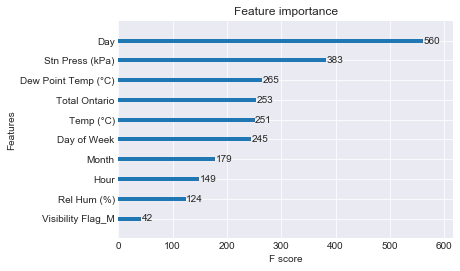

In [449]:
#print out important features and plot
xg.plot_importance(bst_grid.best_estimator_)

# 10 Fold Cross Validation with Optimal Parameters

In [450]:
#10 fold cross-validation 10:07-10:16
cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=seed)

In [451]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.5075,
    'silent': 1.0,
    'scale_pos_weight': float(np.sum(y == 0)) / np.sum(y == 1),
}

In [452]:
n_estimators_range = np.linspace(100, 200, 10).astype('int')

In [457]:
train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    data, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv,
    scoring = 'roc_auc',
)

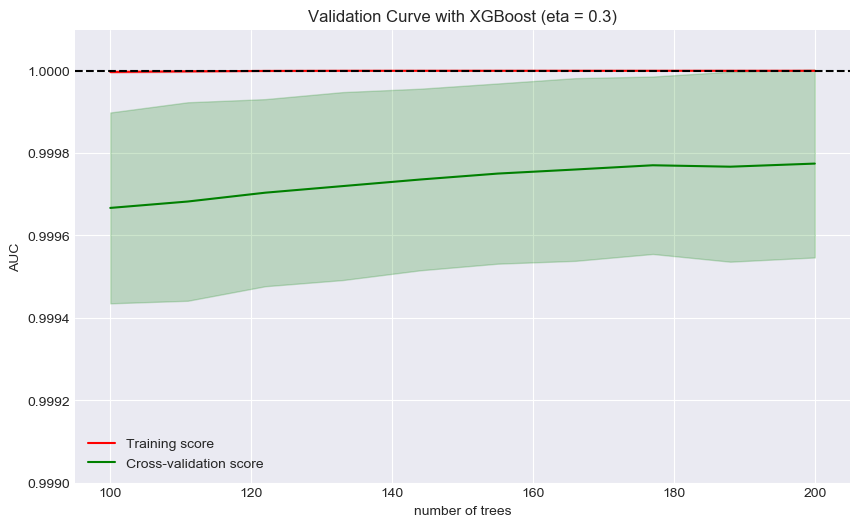

Best cross-validation result (1.00) obtained for 200 trees


In [465]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("AUC")
plt.ylim(0.999, 1.0001)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))